<a href="https://colab.research.google.com/github/vintagedeek/CICIDS2017/blob/master/cicids2017_2020_07_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import pandas as pd
import numpy as np

from collections import OrderedDict, namedtuple
from itertools import product
import time
from IPython.display import display, clear_output
import json

import torch 
from torchvision.transforms import Normalize
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F

from scipy.ndimage.interpolation import shift
from PIL import Image

import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn-whitegrid')

In [119]:
train_url = 'https://raw.githubusercontent.com/r-dube/CICIDS2017/master/MachineLearningCVE/processed/bal-cicids2017.csv'
df_train = pd.read_csv(train_url)

In [120]:
df_train.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,YY
0,53,31065,2,2,68,132,34,34,34.0,0.0,66,66,66.0,0.0,1.035500e+04,1.789123e+04,31014,3,3,3.0,0.000000,3,3,48,48.0,0.000000,48,48,0,0,0,0,64,64,64.381136,64.381136,34,66,46.800000,17.527122,307.200000,0,0,0,0,0,0,0,0,1,58.5,34.0,66.0,64,0,0,0,0,0,0,2,68,2,132,-1,-1,1,32,0.0,0.000000,0,0,0.0,0.000000,0,0,0
1,123,67042799,2,2,96,96,48,48,48.0,0.0,48,48,48.0,0.0,2.230000e+07,3.860000e+07,67000000,43166,67000000,67000000.0,0.000000,67000000,67000000,67000000,67000000.0,0.000000,67000000,67000000,0,0,0,0,64,64,0.029832,0.029832,48,48,48.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,1,60.0,48.0,48.0,64,0,0,0,0,0,0,2,96,2,96,-1,-1,1,32,43166.0,0.000000,43166,43166,67000000.0,0.000000,67000000,67000000,0
2,53,49637,2,2,180,294,90,90,90.0,0.0,147,147,147.0,0.0,1.654567e+04,2.861464e+04,49587,3,3,3.0,0.000000,3,3,47,47.0,0.000000,47,47,0,0,0,0,64,40,40.292524,40.292524,90,147,112.800000,31.220186,974.700000,0,0,0,0,0,0,0,0,1,141.0,90.0,147.0,64,0,0,0,0,0,0,2,180,2,294,-1,-1,1,32,0.0,0.000000,0,0,0.0,0.000000,0,0,0
3,53,48242,1,1,44,92,44,44,44.0,0.0,92,92,92.0,0.0,4.824200e+04,0.000000e+00,48242,48242,0,0.0,0.000000,0,0,0,0.0,0.000000,0,0,0,0,0,0,20,20,20.728825,20.728825,44,92,60.000000,27.712813,768.000000,0,0,0,0,0,0,0,0,1,90.0,44.0,92.0,20,0,0,0,0,0,0,1,44,1,92,-1,-1,0,20,0.0,0.000000,0,0,0.0,0.000000,0,0,0
4,443,90102413,3,3,18,0,6,6,6.0,0.0,0,0,0.0,0.0,1.802048e+07,2.462721e+07,45000562,34973,90067231,45033615.5,2714.582933,45035535,45031696,90067440,45033720.0,3715.139028,45036347,45031093,0,0,0,0,60,96,0.033295,0.033295,0,6,3.428571,3.207135,10.285714,0,0,0,0,1,0,0,0,1,4.0,6.0,0.0,60,0,0,0,0,0,0,3,18,3,0,251,66,2,20,35379.0,574.170706,35785,34973,44998236.5,3288.753639,45000562,44995911,0


In [121]:
df_train['YY'].value_counts()

0     40000
12     8000
11     8000
10     8000
9      8000
8      8000
7      8000
6      8000
5      8000
4      8000
3      8000
2      8000
1      8000
Name: YY, dtype: int64

In [122]:
df_train.iloc[0:40001]['YY'].value_counts()

0    40000
1        1
Name: YY, dtype: int64

In [123]:
df_train = df_train.iloc[32000:]
df_train = df_train.sample(frac=1).reset_index(drop=True) # Here, specifying drop=True prevents .reset_index from creating a column containing the old index entries.
df_train['YY'].value_counts()
# https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows

12    8000
11    8000
10    8000
9     8000
8     8000
7     8000
6     8000
5     8000
4     8000
3     8000
2     8000
1     8000
0     8000
Name: YY, dtype: int64

In [124]:
df_train.iloc[:, -1]

0          7
1          9
2          5
3         10
4         12
          ..
103995     8
103996     5
103997     2
103998     7
103999     9
Name: YY, Length: 104000, dtype: int64

In [127]:
train_set = df_train[0:83200]
train_set = torch.tensor(np.array(train_set), dtype=torch.float32)
train = torch.narrow(train_set, 1, 0, 76)
train_labels = torch.narrow(train_set, 1, 76, 1)
train_labels = torch.tensor(train_labels, dtype=torch.int64).squeeze() # squeeze to make 1D instead of 2D

val_set = df_train[83200:]
val_set = torch.tensor(np.array(val_set), dtype=torch.float32)
val = torch.narrow(val_set, 1, 0, 76)
val_labels = torch.narrow(val_set, 1, 76, 1)
val_labels = torch.tensor(val_labels, dtype=torch.int64).squeeze()
print(train.shape, train_labels.shape, val.shape, val_labels.shape)

torch.Size([83200, 76]) torch.Size([83200]) torch.Size([20800, 76]) torch.Size([20800])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


In [128]:
val_labels[10000:10003]

tensor([11, 10, 10])

In [129]:
val_set[10000:10003, -1]

tensor([11., 10., 10.])

In [130]:
train_labels[45000:45003]

tensor([11,  1,  7])

In [131]:
train_set[45000:45003, -1]

tensor([11.,  1.,  7.])

In [132]:


x = torch.tensor([[1,2,3], [4,5,6]])
torch.narrow(x, 1, 0, 2)

tensor([[1, 2],
        [4, 5]])

In [133]:
#train = torch.narrow(train_all, 1, 0, 76)
#train_labels = torch.narrow(train_all, 1, 76, 1).squeeze() 
#train_labels = torch.tensor(train_labels, dtype=torch.int64)

In [134]:
#train_labels[10000:10002]

In [135]:
#train_all[10000:10002, -1]

In [136]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [137]:
class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

class RunManager():
    def __init__(self):
        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.val_correct = 0
        self.epoch_start_time = None
        
        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None
        
        self.network = None

       
    def begin_run(self, run, network):
        self.run_start_time = time.time()
        
        self.epoch_count = 0
        self.run_params = run
        self.run_count += 1
        
        self.network = network
        
    def end_run(self):
        self.epoch_count = 0
    
    def begin_epoch(self):
        self.epoch_start_time = time.time()
        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.val_correct = 0
    
    def end_epoch(self):
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time
        
        loss = self.epoch_loss / len(train)
        train_accuracy = self.epoch_num_correct / len(train)

        val_accuracy = self.val_correct/len(validation_set)

            
        results = OrderedDict()
        results["run"] = self.run_count
        results['epoch'] = self.epoch_count
        results['loss'] = loss
        results['train_accuracy'] = train_accuracy
        results['val_accuracy'] = val_accuracy
        results['epoch duration'] = epoch_duration
        results['run duration'] = run_duration
        for k, v in self.run_params._asdict().items(): results[k] = v
        self.run_data.append(results)
        df = pd.DataFrame.from_dict(self.run_data, orient='columns')
        clear_output(wait=True)
        display(df)
    
    def track_loss(self, loss):
        self.epoch_loss += loss.item() * 10
    
    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self._get_num_correct(preds, labels)
      
    def track_val_accuracy(self, model):
        with torch.no_grad():
            validation_preds = model(validation_set)
            self.val_correct += validation_preds.argmax(dim=1).eq(validation_labels).sum().item()
   
    @torch.no_grad()
    def _get_num_correct(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()
    
    def save(self, fileName): # save in json and csv
        
        pd.DataFrame.from_dict(self.run_data, orient='columns').to_csv(f'{fileName}.csv')
        
        with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [140]:
validation_set = val.to(device)
validation_labels = val_labels.to(device)

params = OrderedDict(
    lr = [0.0001],
    batch_size = [500],
    device = ['cuda'],
    weight_decay = [0.0, 1.0, 10.0])

m = RunManager()
for run in RunBuilder.get_runs(params):

    network = nn.Sequential(
        nn.Linear(in_features=76, out_features=26),
        nn.Sigmoid(),
        nn.Linear(in_features=26, out_features=13),
        nn.Sigmoid()).to(device)
    
    mini_batches = [train[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
    mini_labels = [train_labels[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
    optimizer = optim.Adam(network.parameters(), lr=run.lr, weight_decay=run.weight_decay)
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

    m.begin_run(run, network)
    for epoch in range(300):
        m.begin_epoch()
        for b in range(0, len(mini_batches)):
            images = mini_batches[b].to(device)
            labels = mini_labels[b].to(device)
            preds = network(images) # pass batch
            loss = F.cross_entropy(preds, labels) # calculate loss
            optimizer.zero_grad() # zero gradients
            loss.backward() # calculate gradients
            optimizer.step() # update weights

            m.track_loss(loss)
            m.track_num_correct(preds, labels)
        m.track_val_accuracy(network)
        m.end_epoch()
        #scheduler.step()
    m.end_run()

pd.DataFrame.from_dict(m.run_data).sort_values('val_accuracy', ascending=False)[0:15]

,run,epoch,loss,train_accuracy,val_accuracy,epoch duration,run duration,lr,batch_size,device,weight_decay
0,1,1,0.051147,0.123954,0.136827,0.267787,0.267793,0.0001,500,cuda,0.0
1,1,2,0.050626,0.188425,0.201779,0.261987,0.558636,0.0001,500,cuda,0.0
2,1,3,0.050122,0.215517,0.250673,0.258412,0.839571,0.0001,500,cuda,0.0
3,1,4,0.049704,0.304303,0.412740,0.250801,1.113211,0.0001,500,cuda,0.0
4,1,5,0.049243,0.426538,0.443894,0.262294,1.399940,0.0001,500,cuda,0.0
...,...,...,...,...,...,...,...,...,...,...,...
895,3,296,0.051465,0.166154,0.153221,0.256579,89.951380,0.0001,500,cuda,10.0
896,3,297,0.051465,0.159916,0.151923,0.271837,90.258765,0.0001,500,cuda,10.0
897,3,298,0.051464,0.164423,0.152067,0.271134,90.565061,0.0001,500,cuda,10.0
898,3,299,0.051464,0.161346,0.152885,0.263102,90.861979,0.0001,500,cuda,10.0


,run,epoch,loss,train_accuracy,val_accuracy,epoch duration,run duration,lr,batch_size,device,weight_decay
250,1,251,0.037753,0.801971,0.806923,0.258594,73.376230,0.0001,500,cuda,0.0
247,1,248,0.037766,0.801683,0.806779,0.268984,72.473486,0.0001,500,cuda,0.0
251,1,252,0.037741,0.802200,0.806538,0.261977,73.670860,0.0001,500,cuda,0.0
248,1,249,0.037761,0.802151,0.806442,0.266046,72.772595,0.0001,500,cuda,0.0
249,1,250,0.037780,0.802007,0.806154,0.271589,73.083225,0.0001,500,cuda,0.0
254,1,255,0.037678,0.802079,0.806106,0.256496,74.546688,0.0001,500,cuda,0.0
242,1,243,0.037902,0.800974,0.806106,0.264246,70.988274,0.0001,500,cuda,0.0
246,1,247,0.037766,0.800901,0.805865,0.255504,72.171273,0.0001,500,cuda,0.0
253,1,254,0.037670,0.801719,0.805673,0.253221,74.257910,0.0001,500,cuda,0.0
243,1,244,0.037834,0.801911,0.805673,0.256416,71.277534,0.0001,500,cuda,0.0


In [139]:
m.save('cicids_batch_lr_grid_search_validation')

# Best Run Data
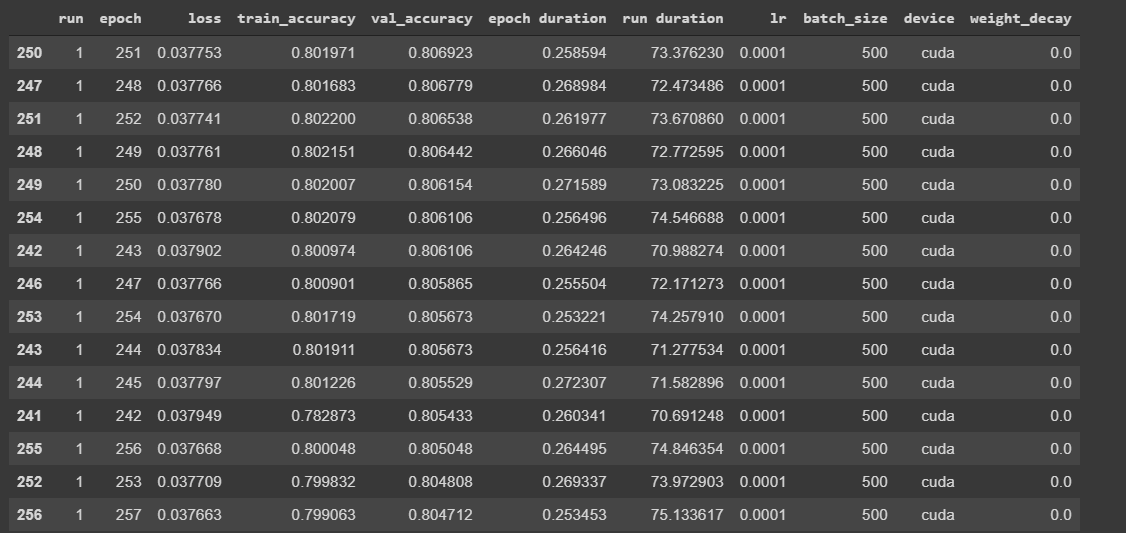


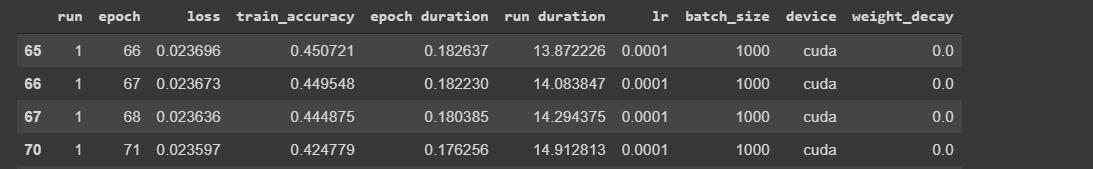

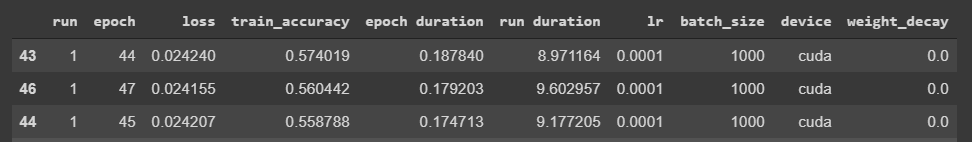

In [97]:
m.val_correct

0

In [98]:
x=network(validation_set)

In [100]:
val_corr = 0
val_corr += x.argmax(dim=1).eq(validation_labels).sum().item()

In [108]:
x.argmax(dim=1)[999:1043]

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0],
       device='cuda:0')

In [110]:
validation_labels

tensor([10, 10, 10,  ..., 12, 12, 12], device='cuda:0')